In [0]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from scipy.stats import mstats

In [0]:
from google.colab import drive
drive.mount('mydrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at mydrive


In [0]:
economic = pd.read_csv('/content/mydrive/My Drive/IE Bootcamp - Math & Stats /data/EconomicModel.csv')
economic.head()

,Country,continent,unemp,expense,gdpgrowth,taxrev,inflation,popgrowth
0,Albania,5,15.22,23.91,3.35,17.56,1.28,-0.16
1,Argentina,2,NaN,26.31,-1.82,12.16,NaN,0.98
2,Australia,4,5.71,26.96,2.83,22.29,1.28,1.50
3,Austria,5,6.01,45.57,1.45,25.67,0.89,1.08
4,Azerbaijan,5,5.00,NaN,-3.10,NaN,12.45,1.12


## Checking the Assumptions

We need to check for:

 * Independency: Our sample size is bigger than the 10% of the population size, then we will probably have dependecy problems
 
 * Homoskedasticity: Equality of population variances


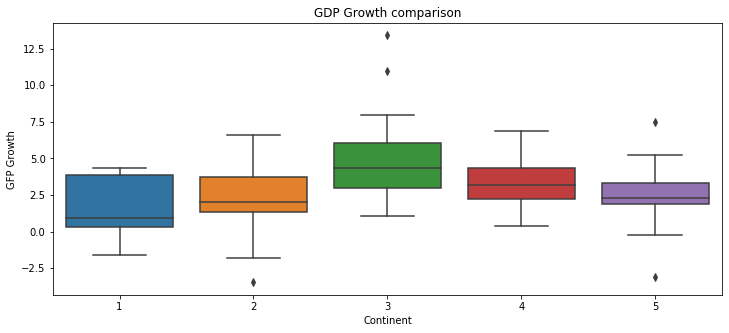

In [0]:
plt.figure(figsize = (12, 5))
g = sns.boxplot(data = economic, x = 'continent', y = 'gdpgrowth')
g.axes.set_title('GDP Growth comparison')
g.axes.set_xlabel('Continent')
g.axes.set_ylabel('GFP Growth')
plt.show()

The boxes (IQRs) seem to be rather similar, so we may not expect any problems with heteroskedasticity. Let's perform Levene's test anyway

In [0]:
ss.levene(economic['gdpgrowth'][economic['continent'] == 1].dropna(),
         economic['gdpgrowth'][economic['continent'] == 2].dropna(),
         economic['gdpgrowth'][economic['continent'] == 3].dropna(),
         economic['gdpgrowth'][economic['continent'] == 4].dropna(),
         economic['gdpgrowth'][economic['continent'] == 5].dropna())

LeveneResult(statistic=0.9487907979535382, pvalue=0.44082068713856426)

Since we find a p-value of 0.44, greater that the usual significance levels, we fail to reject the null hypothesis, meaning that there is no evidence against homoskedasticity.

 * For Normality, we use the following functions

In [0]:
def NormalityTests(x, sig_level):
    '''
    This function computes the p-value and statistics of the Shapiro-Wilk and D'Agostino tests for normality
    It also includes the set of libraries to be loaded in the test (no cheks done)
    
    Inputs:
    
     - x: array of values of the variable to be tested
     - sig_level: significance level to be used in the decision of the test
    
    Output
    
     - p-value, statistic and decision for both tests    
    '''
    from scipy.stats import shapiro
    from scipy.stats import normaltest
    
    shap_stat, shap_p = shapiro(x)
    k2_stat, k2_p = normaltest(x)
    
    print("From the Shapiro Wilk test:\n\nStatistic: ", shap_stat, "\np-value: ", shap_p)
    if shap_p > sig_level:
        print("Fail to reject Normality: No evidence found against normality\n\n")
    else:
        print("Reject Normality: Evidence found against normality\n\n")
    
    print("From the D'Agostino test:\n\nStatistic: ", k2_stat, "\np-value: ", k2_p)
    if k2_p > sig_level:
        print("Fail to reject Normality: No evidence found against normality\n\n")
    else:
        print("Reject Normality: Evidence found against normality\n\n")
             

def HisQQplots(x):
    '''
    This function plots the histogram and qq-plot of an array in order to perform a visual analysis of normality
    
    Inputs:
    
     - x: array to plot
    
    Output:
    
     A plot consisting in two subplots (one for each of the previous ones)
    '''
    # define the different regions
    f, (ax_box, ax_hist) = plt.subplots(2, 
                                        sharex = False, 
                                        gridspec_kw={"height_ratios": (.25, .75)})
    f.set_figheight(8)
    f.set_figwidth(8)
    plt.suptitle('Normality Plots', fontsize = 20)
    # Add a graph in each part
    sns.distplot(x, hist = True, 
                 kde = False, 
                 bins = 10, 
                 hist_kws={'edgecolor':'black'},
                 ax=ax_box)
    ss.probplot(x, plot=sns.mpl.pyplot)
    plt.tight_layout(rect=(0,0,1,0.94))
    plt.show()

then we use them

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


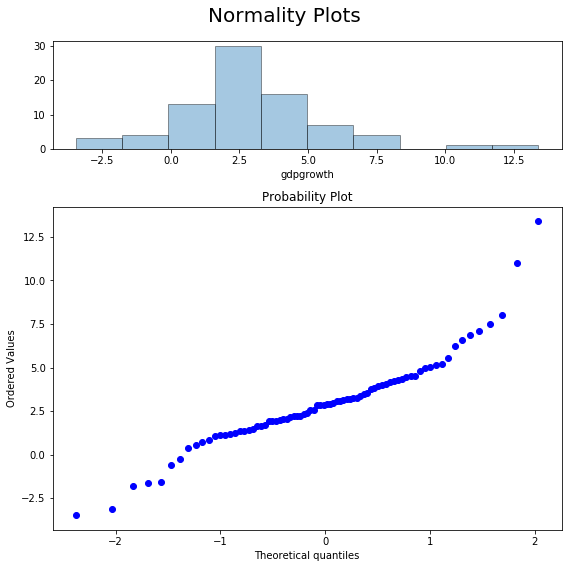

In [0]:
HisQQplots(economic['gdpgrowth'])

from the graphs, the presence of outliers may be indicating that the population is not normally distributed, let's however, make the tests

In [0]:
NormalityTests(economic['gdpgrowth'].dropna(), 0.01)

From the Shapiro Wilk test:

Statistic:  0.9363954663276672 
p-value:  0.0006767841405235231
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  18.925147775644028 
p-value:  7.7706326029631e-05
Reject Normality: Evidence found against normality




since in D'Agostino test we find evidence against normality, we reject it. Therefore, to compare the populations, we must use a non-parametric test: Kruskal-Wallis (remember that this test compares the medians, not the means)

# Kruskal-Wallis test

the function we need is in the `mstats` package so

In [0]:
print("Kruskal Wallis H-test test:\n")

H, pval = mstats.kruskalwallis(economic['gdpgrowth'][economic['continent'] == 1].dropna().values,
                               economic['gdpgrowth'][economic['continent'] == 2].dropna().values,
                               economic['gdpgrowth'][economic['continent'] == 3].dropna().values,
                               economic['gdpgrowth'][economic['continent'] == 4].dropna().values,
                               economic['gdpgrowth'][economic['continent'] == 5].dropna().values)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("\nReject the NULL hypothesis for a 5%: There is evidence in favor of significant differences between the populations.")
if pval > 0.05:
    print("\nFail to Reject the NULL hypothesis for a 5%: There is no evidence in favor of significant differences between the populations")

Kruskal Wallis H-test test:

H-statistic: 12.631485346804471
P-Value: 0.013224103171989141

Reject the NULL hypothesis for a 5%: There is evidence in favor of significant differences between the populations.


Since we have found evidence against the equality of the population medians, we perform a post-hoc analysis. LEt's load the `scikit_posthocs` library

In [0]:
!pip install scikit_posthocs

In [0]:
import scikit_posthocs as sp

In [0]:
sp.posthoc_conover(economic, val_col = 'gdpgrowth', group_col = 'continent', p_adjust = 'holm')

,1,2,3,4,5
1,-1.000000,1.000000,0.027378,1.0,1.000000
2,1.000000,-1.000000,0.030846,1.0,1.000000
3,0.027378,0.030846,-1.000000,1.0,0.038805
4,1.000000,1.000000,1.000000,-1.0,1.000000
5,1.000000,1.000000,0.038805,1.0,-1.000000


From the table we detect (for a 5% of significance level) the differences between:

 * Africa and Asia
 * America and Asia
 * Europe and Asia

